# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 2
### <center> Yoshihiro Shirai

# Training Models and Regression, Part 1

- These lecture notes are partially based on "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition, by Aurelien Geron (O'Reilly), 2022."

- Chapter 4: Linear regression, gradient descent and its variations.

# 0. Overview of the lecture
- Here we consider the simplest machine learning method: linear regression.

- Then we discuss methods for training models using iterative optimization algorithms, specifically Gradient Descent (GD) and Stochastic Gradient Descent (SGD), which are simple yet powerful approaches for training ML models. These algorithms can be used to train linear regression models, but they are also used to train ML models more generally.

- Then in later lectures, we will consider performance measures and use them to select and evaluate models for regression problems, and we will also study classification problems.

- The topics that we discuss today will also be essential when we cover neural networks later in the course.

# 1. Regression

- Goal: Predict the numerical value of a target variable based on a set of features.

- Examples: Predicting median housing prices based on features of the geographic area, predicting credit scores based on features of a person.

- Next, we present linear regression as the first and simplest machine learning model for regression problems. The other type of supervised learning problem are classification problems.

# 1.1 Linear regression
- Problem: given a set of **features** $\mathbf{x} = (x_1,...,x_M)$, predict the target (or response variables) $ y $.

- Linear regression model: $y_n = \theta_0 + \sum_{i=1}^M \theta_i x_{n,i} + \varepsilon_n = \mathbf{x}_n^{T} \mathbf{\theta}+\varepsilon_n$

  - $\theta = (\theta_0,...,\theta_M)$ is the parameter vector (or regression coefficients), $\theta_0$ is the **bias** term and $\theta_1,...,\theta_M$ are **feature weights**
  - $\mathbf{x}_n = (1,x_{n,1},...,x_{n,M}$ is the **feature vector** (or predictors or explantory variables) of the $n$-th instance
  - $\varepsilon_n$ is the **error term**
- This terminology applies to machine learning models more generally, not just linear regression.

- To train the model with the training set $\{(\mathbf{x}_n,y_n)\}^N_{n=1}$, the cost function that we minimize is the mean square error (MSE) $$\text{MSE}(\theta)\frac{1}{N}\sum_{n=1}^N(y_n-\mathbf{x}_n^T\theta)^2=\frac{1}{N}(\mathbf{y}-\mathbf{X}\mathbf{\theta})^T(\mathbf{y}-\mathbf{X}\mathbf{\theta})$$ where
  - $\mathbf{X}$ is the $N\times (M+1)$ matrix of all feature values and $\mathbf{y}$ is vector of all labels $$\mathbf{X}:=\begin{bmatrix} 1 & x_{1,1} & \cdots & x_{1,M} \\ \vdots & \vdots & \ddots & \vdots \\ 1 & x_{N,1} & \cdots & x_{N,M}\end{bmatrix}, \quad \mathbf{y}:=\begin{bmatrix} y_1 \\ \vdots \\ y_N\end{bmatrix}$$

- The minimizer of MSE$(\theta)$ is: $$\theta := (\mathbf{X}^T\mathbf{X})^{−1}\mathbf{X}^⊤\mathbf{y}$$

- Let us fit a linear regression model using Scikit-Learn

- We start by simulating a linear random sample


In [1]:
import numpy as np
np.random.seed(42)

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

- If this were a ML project using real data, we would create a test set first. However, for demonstration, we skip this step here and treat this data $\{(\mathbf{x}_n,y_n)\}^N_{n=1}$ as if it is the training set.

- Scikit-Learn's `LinearRegression` class implements linear regression models, and can be fitted as follows using the `.fit()` method.

In [2]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

- The prediction for the features $\mathbf{x}$ is $\hat{y}=\mathbf{x}^T\hat{\theta}$

- To get predictions on a new set of features, simply pass the feature matrix $\mathbf{X}$ to the `.predict()` method

In [3]:
X_new = np.array([[0], [2]])
y_predict = lin_reg.predict(X_new)
y_predict

array([[4.21509616],
       [9.75532293]])

- We plot the data and the fitted regression line

In [4]:
import matplotlib as mlp
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

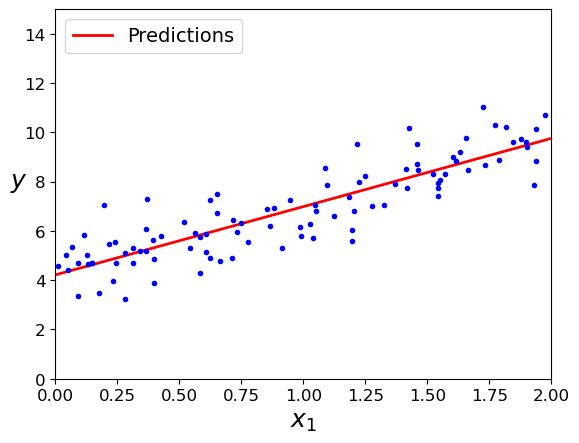

In [5]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

- The formula for $\hat{\theta}$ depends on calculating the (pseudo-) inverse of $\mathbf{X}^T\mathbf{X}$, which has computational complexity of $O(M^2)

- For a very large number of features (e.g. 100,000), the formula is slow to evaluate

- The formula scales linearly with the sample size, that is, it is $O(N)$

- In optimization, such closed-form formulas do not always exist. Even if they do, it may not be feasible to evaluate them (e.g. linear regression for a very large number of features)

- In these cases, we may use iterative optimization algorithms that yield a good solution in reasonable time

- Next, we discuss one such algorithm called Gradient Descent (GD)

# 2. Gradient Descent

- Gradient descent (GD) is a generic optimization algorithm, which we will use for training machine learning models.

- Suppose that you want to minimize a function $f(\theta):\mathbb{R}^M\rightarrow\mathbb{R}$ known as the "cost function" (or "loss function")

- Start with an arbitrary (e.g. random) point $\theta^{(0)}\in \mathbb{R}^M$

- Repeat the following step until "you are near the optimal point" $\theta^{(k+1)} = \theta^{(k)}−\eta_k\nabla f(\theta)^{(k})$

- **Idea**: 
    - $-\nabla f(\theta)$ is the direction of steepest descent of $f$ at a point $\theta$ 
    - For a constant $\eta_k>0$ that is small enough, $\theta^{(k+1)}$ has a better value than $\theta^{(k)}$
    - With each step of GD, the cost function gets better (ideally). Eventually, the algorithm converges to a local minimum

- $\eta_k$ is called the "step size" or "learning rate" of GD

- If it is too small, the algorithm converges slowly. If it is too large, the algorithm may not converge at all!

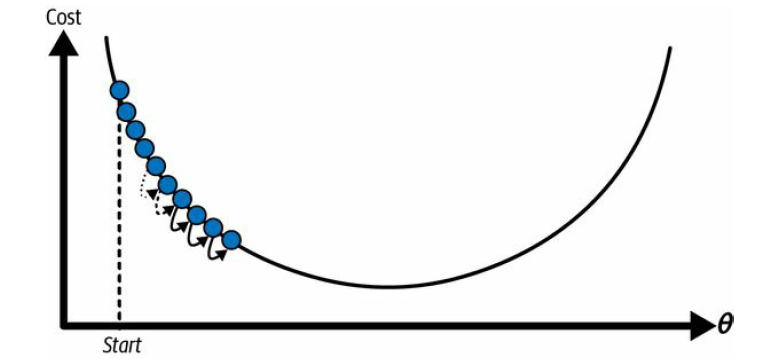

In [6]:
from IPython.display import Image
Image("Figs/GD-2.png", width=600)

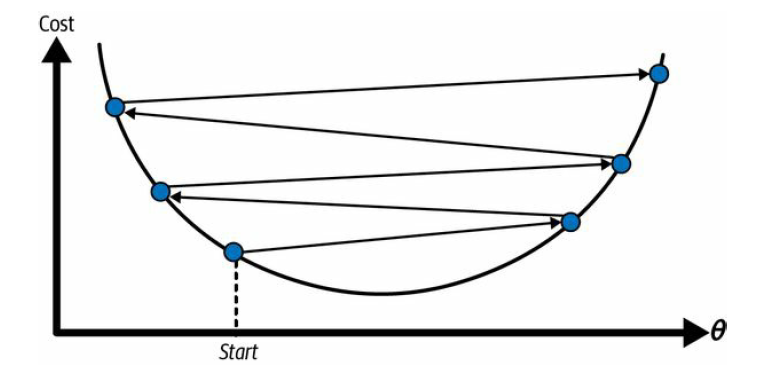

In [7]:
Image("Figs/GD-3.png", width=600)

- A good strategy for choosing the learning rate is "simulated annealing," where the learning rate starts out large and then get smaller and smaller, allowing the GD to converge

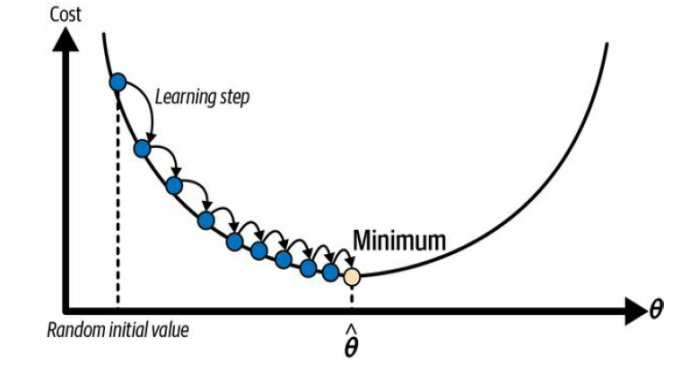

In [8]:
Image("Figs/GD-1.png", width=600)

- GD does not always converge to the global minimum. Depending on the properties of $f$ and the learning rate $\eta_k$, GD may converge to a local minimum, or it may not converge to a local minimum at all

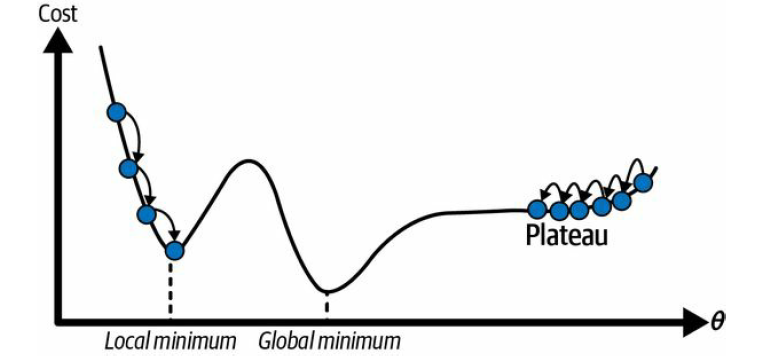

In [9]:
Image("Figs/GD-4.png", width=600)

- When using GD, it is important that features have the same scale, (that is, no feature is much smaller or much larger than the others). Otherwise, GD takes more time to converge

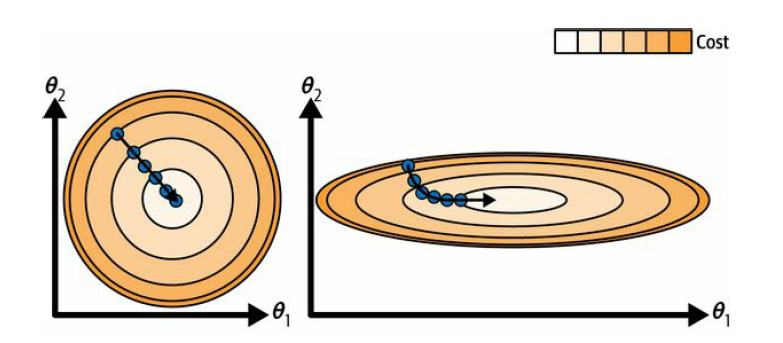

In [10]:
Image("Figs/GD-5.png", width=800)

- If the cost function is convex and is sufficiently regular (more precisely, if its derivative is Lipschitz continuous), the convergence of GD is guaranteed if the learning rate is small enough

- For general functions, there is no guarantee of convergence. Furthermore, for convergent cases, the convergence rate may not be fast. In general, one may need to "tweak" the algorithm to make it work

## 2.1. Batch GD

- In each step of GD, we need to find the gradient at the current parameter values

- For example, in linear regression $$\nabla_{\theta} \text{MSE}(\theta)=\nabla_{\theta} \frac{1}{N}(\mathbf{y}-\mathbf{X}\theta)^T(\mathbf{y}−\mathbf{X}\theta)=2N\mathbf{X}^⊤(\mathbf{X}\theta−\mathbf{y})$$

- The GD iteration then becomes $$\theta^{(k+1)}=\theta^{(k)}-\frac{2\eta_k}{N}\mathbf{X}^T(\mathbf{X}\theta^{(k)}-\mathbf{y})$$

- Note that this formula involves calculation over the full training set. For this reason, it is called batch gradient descent

- Batch GD is slow for large training sets (i.e. large $N$). However, it scales well with the number of features (i.e. $M$). So for a large number of features (e.g. 100,000), GD is much faster than the closed form formula

- Let us implement a Batch GD for fitting linear regression

In [11]:
from sklearn.preprocessing import add_dummy_feature

eta = 0.1
n_epochs = 1000
N = 100

X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    gradients = 2/N * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients
theta


array([[4.21509616],
       [2.77011339]])

- We obtain the same answer as the closed-form formula, after 1000 iterations (for batch GD, an iteration is also called an "epoch").

- Let us investigate the relationship between the size of the learning rate and convergence of GD

In [12]:
import matplotlib as mpl

X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance
def plot_gradient_descent(theta, eta):
    N = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2/N * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

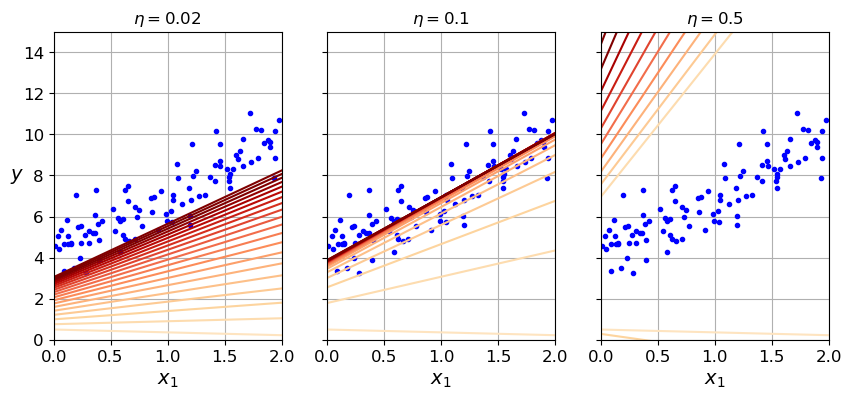

In [13]:
np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize=(10, 4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

- In the left plot, GD will eventually reach the solution, but the learning rate is too low.

- In the middle plot, the solution is reached quickly, the learning rate is good.

- In the right plot, GD diverges, the learning rate is too large.

## 2.2. Stochastic GD

- The main shortcoming of batch GD is that, for large training sets, evaluating the gradient at each iteration may take a long time

- Stochastic gradient descent (SGD) is a variation of GD in which only one random instance from the training set is used for approximating the gradient

- For example, the SGD iteration for linear regression is $$\theta^{(k+1)}=\theta^{(k)}-2\eta_k\mathbf{x}_{n_k}^T(\mathbf{x}_{n_k}\theta^{(k)}-\mathbf{y})$$ where $n_k$ is a random number between $1,...,N$

    - Instead of using the whole training set $(\mathbf{y},\mathbf{X})$, we use one random instance $(y_{n_k}, \mathbf{x}_{n_k})$ to evaluate the gradient

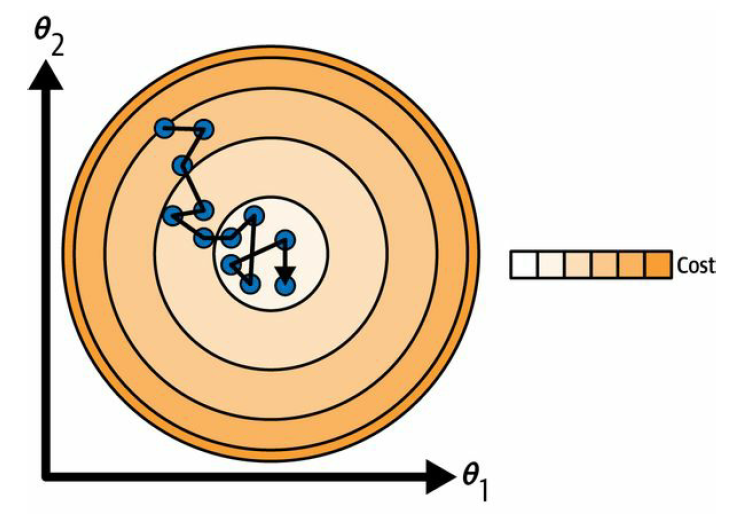

In [14]:
Image("Figs/GD-6.png", width=600)

- SGD is effective for scenarios where the training set is so large it cannot fit into the memory of one machine

- SGD is an example of an "out-of-core" learning algorithm. These algorithms load a part of the training set at a time, run the training step on that part, and repeat the process until it has run on all of the data

- The algorithm is much less regular than batch GD. In fact, there is no guarantee that the cost function gets better at each step (since the gradient is approximated). The cost function will fluctuate over iterations, but (ideally) it will decrease on average

- Unlike batch GD, SGD continues to fluctuate once it gets near a minimum. There is no guaranteed convergence to a local minimum. But SGD can find a "good solution"

- The random nature of SGD is helpful to escape from local minima (that are not the global minimum)

- It is best to use simulated annealing with SGD, that is, start out with a large learning rate and then decrease the learning rate with time to converge to a point (hopefully, the global minimum)

- Let us implement a simple SGD algorithm for training linear regression

- We start by choosing a "learning schedule", that is the learning rate as a function of the number of iterations

In [15]:
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

- We repeat rounds of $N$ iterations, each of which called an "epoch". During each epoch, we "go through the training set" once

In [16]:
n_epochs = 50
theta_path_sgd = []
np.random.seed(42)

theta = np.random.randn(2,1)
for epoch in range(n_epochs):
    for i in range(N):
        random_index = np.random.randint(N)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(epoch * N + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)
theta

array([[4.21076011],
       [2.74856079]])

- Note that after 50 epochs, we find a good solution. Previously, we used a batch GD that went through 1000 iterations of training set.

- There is no need to write your own code. To perform linear regression using SGD, we can use Scikit-Learn's `SGDRegressor class`

In [17]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, eta0=0.1,
                       penalty=None, tol=None,random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([4.16782089]), array([2.72603052]))

- In batch GD, we used the whole training set at each iteration. In SGD, we used only one instance

- There is a variation of GD called "**mini-batch GD**" which takes the middle ground, by using a sub-sample of the training set to compute the gradient at each iteration

- Generally speaking, mini-batch GD is less random than SGD. Therefore, it may be faster in reaching a good solution. However, it may be harder for mini-batch GD to escape local minima